In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

In [2]:
# -------- SETTINGS --------
SEEDS = [42, 43, 44, 45, 46]
ALGORITHMS = ['alternating','alternating_bias', 'best_of_opposite', 'random_pairing']
SCENARIOS = ['GapJumper-v0', 'CaveCrawler-v0']
CSV_FOLDER = '../results_coevolution'
METRIC = 'Best Fitness'  # The column we're analyzing
GENERATION_COL = 'Generation'
FONT_SIZE = 12
plt.rcParams.update({'font.size': FONT_SIZE})
fitness_values = {}

def load_data(algorithm, scenario):
    """
    Load all runs for a specific algorithm and scenario across different seeds
    Returns a list of DataFrames with added 'Seed' column
    """
    base_path = None
    # Handle special case for random_search
    if algorithm == 'alternating':
        base_path = os.path.join(CSV_FOLDER, 'alternating')
    elif algorithm == 'alternating_bias':
        base_path = os.path.join(CSV_FOLDER, 'alternating_bias')
    elif algorithm == 'best_of_opposite':
        base_path = os.path.join(CSV_FOLDER, 'best_of_opposite')
    elif algorithm == 'random_pairing':
        base_path = os.path.join(CSV_FOLDER, 'random_pairing')

    if scenario == 'GapJumper-v0':
        scenario_path = os.path.join(base_path, 'gap')
    elif scenario == 'CaveCrawler-v0':
        scenario_path = os.path.join(base_path, 'cave')
    
    dfs = []
    for seed in SEEDS:
        # Other algorithms follow standard pattern
        file_name = f"{algorithm}_{scenario}_seed_{seed}.csv"
        
        file_path = os.path.join(scenario_path, file_name)
        #print(f"Looking for: {file_path}")
        
        if os.path.exists(file_path):
            try:
                df = pd.read_csv(file_path)
                df['Seed'] = seed
                df['Scenario'] = scenario
                dfs.append(df)
                #print(f"Successfully loaded {file_path}")
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
        else:
            print(f"File not found: {file_path}")
    
    return dfs

def get_final_fitness(runs):
    """Extract final fitness values from all runs"""
    return [run[METRIC].iloc[-1] for run in runs]

def friedman_test(*samples):
    """Perform Friedman test with simplified output"""
    stat, p = stats.friedmanchisquare(*samples)
    print(f"\nFriedman Test: χ²={stat:.3f}, p={p:.3f}")
    if p < 0.05:
        print("Significant differences found (p < 0.05)")
    return stat, p

def plot_evolution(all_runs, scenario):
    """Plot fitness evolution with confidence intervals"""
    plt.figure(figsize=(10, 6))
    
    for algo, runs in all_runs.items():
        if not runs:
            continue
            
        # Calculate mean and std across runs
        gens = runs[0][GENERATION_COL]
        fitness = np.array([run[METRIC] for run in runs])
        mean = np.mean(fitness, axis=0)
        std = np.std(fitness, axis=0)
        
        plt.plot(gens, mean, label=algo.replace('_', ' '))
        plt.fill_between(gens, mean-std, mean+std, alpha=0.2)
    
    plt.title(f"Fitness Evolution ({scenario})")
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"fitness_{scenario}.png", dpi=120)
    plt.show()

def main():
    # Load all data
    print("Loading data...")
    data = {
        algo: {
            scen: load_data(algo, scen) 
            for scen in SCENARIOS
        } 
        for algo in ALGORITHMS
    }

    # Analyze each scenario
    for scenario in SCENARIOS:
        print(f"\n===== Analyzing {scenario} =====")
        
        # Get final fitness values for all algorithms
        final_values = {
            algo: get_final_fitness(runs[scenario])
            for algo, runs in data.items()
            if runs[scenario]  # Only if we have data
        }
        
        # Print All values of each algorithm for the scenario and each run and store them in a dictionary
        print("\nAll fitness values:")
        for algo, values in final_values.items():
            fitness_values[algo] = values
            print(f"{algo:15}: {values}")
            
        
        # Perform Friedman test
        friedman_test(*final_values.values())
        
        # Plot evolution
        plot_evolution(
            {algo: data[algo][scenario] for algo in ALGORITHMS},
            scenario
        )
        
        # Show final values
        print("\nFinal fitness values:")
        for algo, values in final_values.items():
            print(f"{algo:15}: {np.mean(values):.3f} ± {np.std(values):.3f}")


Loading data...
File not found: ../results_coevolution\best_of_opposite\cave\best_of_opposite_CaveCrawler-v0_seed_42.csv
File not found: ../results_coevolution\best_of_opposite\cave\best_of_opposite_CaveCrawler-v0_seed_43.csv
File not found: ../results_coevolution\best_of_opposite\cave\best_of_opposite_CaveCrawler-v0_seed_44.csv
File not found: ../results_coevolution\best_of_opposite\cave\best_of_opposite_CaveCrawler-v0_seed_45.csv
File not found: ../results_coevolution\best_of_opposite\cave\best_of_opposite_CaveCrawler-v0_seed_46.csv

===== Analyzing GapJumper-v0 =====

All fitness values:
alternating    : [0.0, 0.8613143498697658, 0.6767828013988771, 0.0, 1.7170551530793372]
alternating_bias: [0.1819378261221371, 1.856337422788916, 2.038827191422657, 1.89254699861224, 1.913104863268764]
best_of_opposite: [1.90994977712066, 1.957929516475552, 2.083132118966021, 1.9594195206308611, 1.327544044417786]
random_pairing : [0.3902730075533797, 1.1295988250747668, 0.6199288213435337, 1.075469

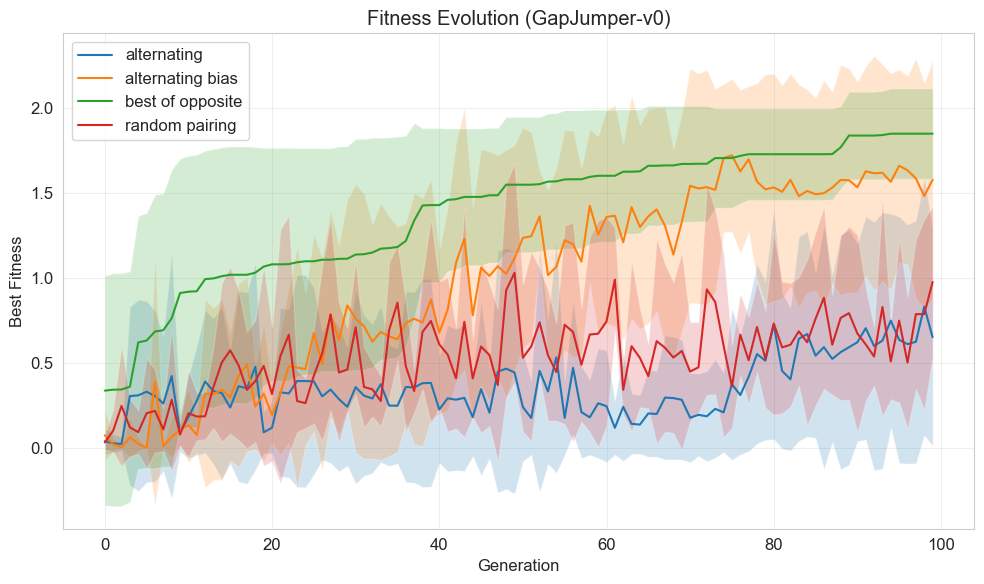


Final fitness values:
alternating    : 0.651 ± 0.637
alternating_bias: 1.577 ± 0.700
best_of_opposite: 1.848 ± 0.266
random_pairing : 0.976 ± 0.442

===== Analyzing CaveCrawler-v0 =====

All fitness values:
alternating    : [0.0, 0.8613143498697658, 0.6767828013988771, 0.0, 1.7170551530793372]
alternating_bias: [0.1819378261221371, 1.856337422788916, 2.038827191422657, 1.89254699861224, 1.913104863268764]
random_pairing : [0.3902730075533797, 1.1295988250747668, 0.6199288213435337, 1.0754694813023498, 1.6631262526524355]

Friedman Test: χ²=5.200, p=0.074


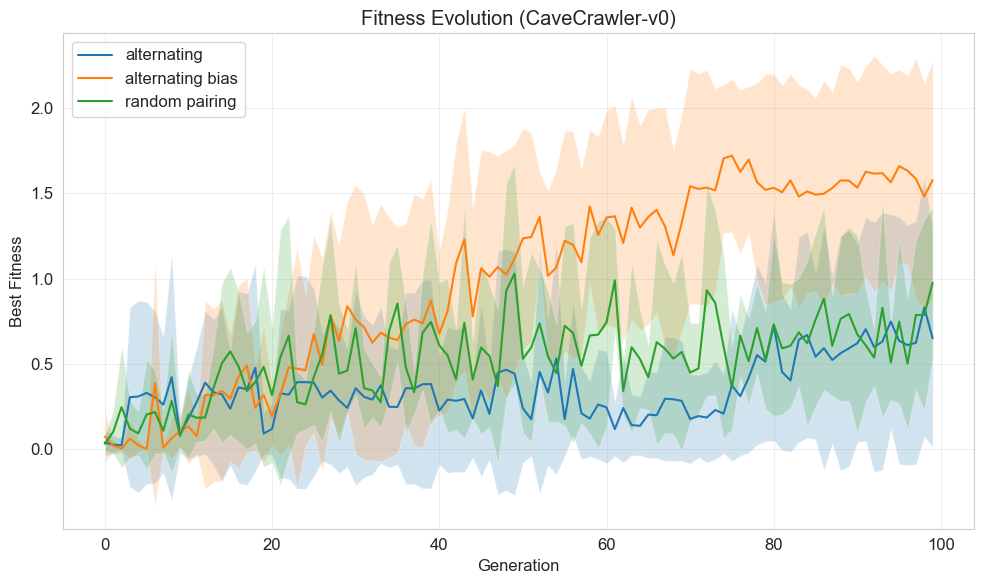


Final fitness values:
alternating    : 0.651 ± 0.637
alternating_bias: 1.577 ± 0.700
random_pairing : 0.976 ± 0.442


In [3]:

if __name__ == "__main__":
    sns.set_style("whitegrid")
    plt.rcParams['font.size'] = 12
    main()

In [4]:
from itertools import combinations

def compare_algorithms(algorithm_results, alpha=0.05):
    """
    Compare all algorithm pairs using Wilcoxon signed-rank test
    with Bonferroni correction.
    
    Parameters:
    - algorithm_results: dict {algorithm_name: list_of_fitness_scores}
    - alpha: significance level (default 0.05)
    
    Returns:
    - List of significant comparisons with p-values
    """
    # Get all possible algorithm pairs to compare
    algorithms = list(algorithm_results.keys())
    pairs = list(combinations(algorithms, 2))
    
    # Bonferroni correction
    corrected_alpha = alpha / len(pairs)
    
    print(f"Comparing {len(algorithms)} algorithms ({len(pairs)} pairs)")
    print(f"Significance level: {alpha} (Bonferroni-corrected α = {corrected_alpha:.4f})")
    
    # Store significant results
    significant = []
    
    # Compare each pair
    for alg1, alg2 in pairs:
        # Get the fitness scores for this pair
        data1 = algorithm_results[alg1]
        data2 = algorithm_results[alg2]
        
        # Run Wilcoxon test
        stat, p = stats.wilcoxon(data1, data2)
        
        # Check significance
        is_significant = p < corrected_alpha
        if is_significant:
            significant.append((alg1, alg2, p))
        
        # Print all results (comment out if you only want significant ones)
        print(f"{alg1} vs {alg2}: p = {p:.4f} {'*' if is_significant else ''}")
    
    return significant

if __name__ == "__main__":
    # Your final fitness data (replace with actual data)
    
    # Run comparisons
    significant_pairs = compare_algorithms(fitness_values)
    
    # Print summary
    print("\nSignificant differences found:")
    for alg1, alg2, p in significant_pairs:
        print(f"- {alg1} vs {alg2}: p = {p:.4f}")

Comparing 4 algorithms (6 pairs)
Significance level: 0.05 (Bonferroni-corrected α = 0.0083)
alternating vs alternating_bias: p = 0.0625 
alternating vs best_of_opposite: p = 0.1250 
alternating vs random_pairing: p = 0.3125 
alternating_bias vs best_of_opposite: p = 0.4375 
alternating_bias vs random_pairing: p = 0.1250 
best_of_opposite vs random_pairing: p = 0.1250 

Significant differences found:
